In [98]:
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
from torchvision import models
from torchvision.models.resnet import BasicBlock, _resnet
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
import math
from collections import Counter
import statistics
from PIL import Image
import krippendorff
import random

from sklearn.metrics import hamming_loss
import statsmodels.api as sm
import statsmodels.stats.api as smi
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import mean_absolute_error


In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

cuda:0
True
2.0.1
11.8


In [100]:
#train val split

In [101]:
#list of all files
import os
annos_directory_path = '/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/annos/'
annos_file_list = os.listdir(annos_directory_path)

In [102]:
image_directory_path = "/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/JPEGImages"
image_file_list = os.listdir(image_directory_path)

In [103]:
#names of all training files
train_file = '/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
with open(train_file, 'r') as file:
    train_file_names = [line.strip() for line in file]

In [104]:
#names of all val files
val_file = '/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
with open(val_file, 'r') as file:
    val_file_names = [line.strip() for line in file]

In [105]:
#split image files into train and val
train_image_files = []
val_image_files = []
for index,file in enumerate(image_file_list):
    file_name = file.replace(".jpg","")
    if file_name in train_file_names:
        train_image_files.append(file)
    elif file_name in val_file_names:
        val_image_files.append(file)

In [106]:
#split label files into train and val
train_label_files = []
val_label_files = []
for index,file in enumerate(annos_file_list):
    file_name = file.replace(".txt","")
    if file_name in train_file_names:
        train_label_files.append(file)
    elif file_name in val_file_names:
        val_label_files.append(file)

In [107]:
#creating labels and probability distributions

In [108]:
#reads annos for train
train_annos = []
for file_anno in train_label_files:
    file_path = os.path.join(annos_directory_path, file_anno)
    with open(file_path, mode = 'r', encoding = 'utf-8-sig') as file:
        lines = file.readlines()

    single_image_annos = []
    for line in lines:
        line = line.split(' ')
        line = [i.strip() for i in line]
        single_image_annos.append(line)
    
    train_annos.append(single_image_annos)

In [109]:
#gets only the classes for train labels
train_classes_annos = []
for j in range(len(train_annos)):
    only_class = []
    for i in train_annos[j]:
        only_class.append(i[0])
    train_classes_annos.append(only_class)

In [110]:
print(train_classes_annos)

[['car'], ['person', 'horse'], ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person'], ['car'], ['aeroplane', 'aeroplane', 'person', 'person'], ['aeroplane', 'aeroplane', 'aeroplane'], ['train', 'train'], ['person', 'person', 'person', 'diningtable'], ['dog'], ['train', 'train'], ['chair', 'cat'], ['car', 'chair'], ['bird', 'person'], ['boat', 'boat'], ['bird'], ['person', 'person', 'person'], ['pottedplant', 'pottedplant', 'boat', 'person'], ['cat', 'cat'], ['dog', 'dog'], ['car', 'person', 'person', 'person', 'person', 'person'], ['person', 'person', 'person', 'chair'], ['car', 'car', 'car'], ['tvmonitor', 'person', 'person'], ['dog', 'chair'], ['cat'], ['bicycle', 'bicycle', 'bicycle', 'person', 'person', 'person'], ['person', 'horse', 'person', 'horse'], ['car'], ['person', 'person', 'person', 'person'], ['dog', 'sofa'], ['bird'], ['chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair'], ['car', 'car', 'car', 'car'], ['boat', 'boat'], ['person', 'car'], ['car', 'car

In [111]:
#reads annos for val
val_annos = []
for file_anno in val_label_files:
    file_path = os.path.join(annos_directory_path, file_anno)
    with open(file_path, mode = 'r', encoding = 'utf-8-sig') as file:
        lines = file.readlines()

    single_image_annos = []
    for line in lines:
        line = line.split(' ')
        line = [i.strip() for i in line]
        single_image_annos.append(line)
    
    val_annos.append(single_image_annos)

In [112]:
#gets only the classes for val labels
val_classes_annos = []
for j in range(len(val_annos)):
    only_class = []
    for i in val_annos[j]:
        only_class.append(i[0])
    val_classes_annos.append(only_class)

In [113]:
#class to number dictionary
class_dict = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

In [114]:
#class to number conversion for train set
train_class_numbers = train_classes_annos
for annotation in range(len(train_classes_annos)):
    for j in range(len(train_classes_annos[annotation])):
        train_class_numbers[annotation][j] = class_dict.get(train_classes_annos[annotation][j])

In [115]:
print(train_class_numbers)

[[6], [14, 12], [1, 1, 1, 14, 14, 14], [6], [0, 0, 14, 14], [0, 0, 0], [18, 18], [14, 14, 14, 10], [11], [18, 18], [8, 7], [6, 8], [2, 14], [3, 3], [2], [14, 14, 14], [15, 15, 3, 14], [7, 7], [11, 11], [6, 14, 14, 14, 14, 14], [14, 14, 14, 8], [6, 6, 6], [19, 14, 14], [11, 8], [7], [1, 1, 1, 14, 14, 14], [14, 12, 14, 12], [6], [14, 14, 14, 14], [11, 17], [2], [8, 8, 8, 8, 8, 8, 8], [6, 6, 6, 6], [3, 3], [14, 6], [6, 6], [19, 14], [14, 13], [13, 14], [11, 14], [14, 12], [14], [19], [2], [14, 8], [14, 14, 17], [12, 14, 14], [18], [14, 14, 14, 14, 14, 4, 4], [5], [7], [13], [6, 6, 14], [10, 14, 14, 4, 4, 14, 14, 14, 14, 14, 14, 14, 14, 8, 8], [16, 16], [0], [8, 8, 8, 8, 10, 17, 15], [7], [10, 4], [0], [14, 14], [6], [6, 6], [14, 14, 14], [11, 14], [8, 14, 14, 14, 14], [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 5], [2, 2], [6, 3], [9, 9, 9, 9], [15, 15], [6], [18], [6], [6, 6, 6, 14], [0], [8, 8, 8, 14], [6], [1, 1, 14, 14, 14, 14, 14, 14, 14, 14], [4], [12], [10, 8, 8, 8, 8, 19], [6], [1

In [116]:
#class to number conversion for val set
val_class_numbers = val_classes_annos
for annotation in range(len(val_classes_annos)):
    for j in range(len(val_classes_annos[annotation])):
        val_class_numbers[annotation][j] = class_dict.get(val_classes_annos[annotation][j])

In [117]:
def convert_to_encoded(sample):
    encoded = [0 for y in range(20)]
    for i in sample:
        encoded[i] = encoded[i] + 1
    return encoded

In [118]:
#encode train set
train_encoded_list = []
for i in range(len(train_class_numbers)):
    train_encoded_list.append(convert_to_encoded(train_class_numbers[i]))

In [119]:
print(train_encoded_list)

[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0], [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 

In [120]:
import copy
train_distributions = copy.deepcopy(train_encoded_list)
for annotation in range(len(train_distributions)):
    train_distributions[annotation] = [a/sum(train_distributions[annotation]) for a in train_distributions[annotation]]
print(train_distributions)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [121]:
import copy
train_binary = copy.deepcopy(train_encoded_list)

for i in range(len(train_binary)):
    for k in range(len(train_binary[i])):
        if train_binary[i][k] == 0:
            continue
        elif train_binary[i][k] != 0:
            train_binary[i][k] = 1.0

In [122]:
#encode train set
val_encoded_list = []
for i in range(len(val_class_numbers)):
    val_encoded_list.append(convert_to_encoded(val_class_numbers[i]))

In [123]:
val_distributions = copy.deepcopy(val_encoded_list)
for annotation in range(len(val_distributions)):
    val_distributions[annotation] = [a/sum(val_distributions[annotation]) for a in val_distributions[annotation]]
print(val_distributions)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [124]:

val_binary = copy.deepcopy(val_encoded_list)

for i in range(len(val_binary)):
    for k in range(len(val_binary[i])):
        if val_binary[i][k] == 0:
            continue
        elif val_binary[i][k] != 0:
            val_binary[i][k] = 1.0

In [125]:
train_labels = torch.tensor(train_distributions)
val_labels = torch.tensor(val_distributions)

In [126]:
print(train_labels)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [127]:
print(val_labels.shape)

torch.Size([2510, 20])


In [128]:
'''import os
import numpy as np
from PIL import Image

def calculate_mean_std(dataset_dir):
    mean = np.zeros(3)
    std = np.zeros(3)
    num_samples = 0

    for root, dirs, files in os.walk(dataset_dir):
        for filename in files:
            if filename.endswith(".jpg"):
                img_path = os.path.join(root, filename)
                img = Image.open(img_path).convert("RGB")
                img = np.array(img) / 255.0  # Convert image to NumPy array and scale to [0, 1]

                mean += img.mean((0, 1))
                std += img.std((0, 1))
                num_samples += 1

    mean /= num_samples
    std /= num_samples

    return mean, std

custom_mean, custom_std = calculate_mean_std('/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/JPEGImages')
print("Custom Mean:", custom_mean)
print("Custom Std:", custom_std)'''


'import os\nimport numpy as np\nfrom PIL import Image\n\ndef calculate_mean_std(dataset_dir):\n    mean = np.zeros(3)\n    std = np.zeros(3)\n    num_samples = 0\n\n    for root, dirs, files in os.walk(dataset_dir):\n        for filename in files:\n            if filename.endswith(".jpg"):\n                img_path = os.path.join(root, filename)\n                img = Image.open(img_path).convert("RGB")\n                img = np.array(img) / 255.0  # Convert image to NumPy array and scale to [0, 1]\n\n                mean += img.mean((0, 1))\n                std += img.std((0, 1))\n                num_samples += 1\n\n    mean /= num_samples\n    std /= num_samples\n\n    return mean, std\n\ncustom_mean, custom_std = calculate_mean_std(\'/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/JPEGImages\')\nprint("Custom Mean:", custom_mean)\nprint("Custom Std:", custom_std)'

In [129]:
transform_train = transforms.Compose([
    #transforms.RandomCrop(, padding=4),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4485348, 0.42499675, 0.39198778], std=[0.24029811, 0.23445981, 0.23704079])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4485348, 0.42499675, 0.39198778], std=[0.24029811, 0.23445981, 0.23704079])
])

In [130]:
image_dir = '/media/scratch/datasets/voc2007/VOCdevkit/VOC2007/JPEGImages'
class VOC2007Dataset(Dataset):
        def __init__(self, image_dir,image_files, labels, transform):
            self.image_dir = image_dir
            self.image_files = image_files
            self.labels = labels
            self.transform = transform
        def __len__(self):
            return len(self.image_files)
        def __getitem__(self,index):
            image_name = self.image_files[index]
            image = Image.open(os.path.join(self.image_dir,image_name))    
            label = self.labels[index]

            if self.transform:
                image = self.transform(image)

            return image,label


In [131]:
train_set = VOC2007Dataset(image_dir,train_image_files,train_labels,transform = transform_train)
val_set = VOC2007Dataset(image_dir,val_image_files,val_labels,transform = transform_test)

In [132]:
print(train_set.labels)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [133]:
voc_TrainLoader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2) #DataLoader with Noise
voc_ValLoader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=2) #Testing DataLoader

In [134]:
'''import PreResNet
baseline_model = PreResNet.ResNet50()
baseline_model.to(device)'''

'import PreResNet\nbaseline_model = PreResNet.ResNet50()\nbaseline_model.to(device)'

In [135]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load the pretrained ResNet-50 model
baseline_model = models.resnet50(pretrained=True)

# Access the original fully connected layer
original_fc = baseline_model.fc

# Specify the number of classes in your task
num_classes = 20

# Define a new fully connected layer
new_fc = nn.Linear(in_features=2048, out_features=num_classes)

# Replace the original fully connected layer with the new one
baseline_model.fc = new_fc
baseline_model.to(device)

/home/kevin/anaconda3/envs/kevGPU/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kevin/anaconda3/envs/kevGPU/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [136]:
'''for name, param in baseline_model.named_parameters():
    if name.startswith('fc.'):  # Only allow gradients for the new output layer
        param.requires_grad = True
    else:
        param.requires_grad = False'''


"for name, param in baseline_model.named_parameters():\n    if name.startswith('fc.'):  # Only allow gradients for the new output layer\n        param.requires_grad = True\n    else:\n        param.requires_grad = False"

In [137]:
num_epochs = 100
learning_rate = 0.001
#criterion = nn.BCEWithLogitsLoss()
pos_weight = torch.tensor([1,1,1,1,1,1,0.25,1,1,1,1,1,1,1,0.25,1,1,1,1,1]).to(device)  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.1)

In [138]:
n_total_steps = len(voc_TrainLoader)
print(n_total_steps)
epoch = 0
for epoch in range(num_epochs):
    loss_trainList = []
    loss_trainAvg = 0
    for step,(data, labels) in enumerate(voc_TrainLoader):
        data = data.to(device) 
        #print(data[0])
        labels = labels.to(device)
        #print(labels.shape)
        #print(labels)
        optimizer.zero_grad()
        outputs = baseline_model(data)
        #print(outputs.shape)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss_trainList.append(loss)
        loss.backward()
        optimizer.step()

        if(step%10 == 9):
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{n_total_steps}], Loss: {loss.item()}")
    scheduler.step()
    #print(" ")
    loss_trainAvg = sum(loss_trainList)/len(loss_trainList)
    #print(len(loss_list))
    print(f"Loss Train Avg: {loss_trainAvg}")
    print("completed training")
    print(" ")
        
    baseline_model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        mean_error_list = []
        for data, labels in voc_ValLoader:  # Replace 'test_loader' with your DataLoader for the test set
            data = data.to(device)
            labels = labels.to(device)
            outputs = baseline_model(data)
            
            #print(len(outputs.flatten()))
            
            predictions = torch.sigmoid(outputs)
            mean_abs_error = mean_absolute_error(labels.flatten().cpu(), predictions.flatten().cpu())
            mean_error_list.append(mean_abs_error)
        mean_abs_error_complete = sum(mean_error_list)/len(mean_error_list)
    print(f"{epoch+1}: Mean Absolute Error: {mean_abs_error_complete}")
    print(" ")
# If you need other metrics (precision, recall, F1-score), you can calculate them using sklearn.metrics.
# You may need to convert tensors to NumPy arrays for this.


79
Epoch [1/100], Step [10/79], Loss: 0.5645972490310669
Epoch [1/100], Step [20/79], Loss: 0.36363112926483154
Epoch [1/100], Step [30/79], Loss: 0.2636233866214752
Epoch [1/100], Step [40/79], Loss: 0.22045043110847473
Epoch [1/100], Step [50/79], Loss: 0.18215425312519073
Epoch [1/100], Step [60/79], Loss: 0.16605162620544434
Epoch [1/100], Step [70/79], Loss: 0.1685352325439453
Loss Train Avg: 0.292568176984787
completed training
 
1: Mean Absolute Error: 0.11167984342650522
 
Epoch [2/100], Step [10/79], Loss: 0.16203509271144867
Epoch [2/100], Step [20/79], Loss: 0.15626735985279083
Epoch [2/100], Step [30/79], Loss: 0.1546405851840973
Epoch [2/100], Step [40/79], Loss: 0.1498447209596634
Epoch [2/100], Step [50/79], Loss: 0.13063356280326843
Epoch [2/100], Step [60/79], Loss: 0.15751245617866516
Epoch [2/100], Step [70/79], Loss: 0.13914257287979126
Loss Train Avg: 0.14765231311321259
completed training
 
2: Mean Absolute Error: 0.07575363458334645
 
Epoch [3/100], Step [10/79],

In [146]:

with torch.no_grad():
    y_pred = torch.sigmoid(baseline_model(val_set[2000][0].to(device).unsqueeze(0)))
    y_pred = y_pred.squeeze()
    image, label = val_set[2000]
    print(y_pred, label)
    x = mean_absolute_error(label.cpu(), y_pred.cpu())
    print(x)

tensor([6.6711e-06, 6.6966e-05, 3.8423e-05, 5.0802e-06, 2.7182e-05, 1.4223e-06,
        2.1833e-02, 1.9965e-07, 2.9045e-07, 1.3154e-06, 2.0819e-07, 8.3014e-07,
        6.2896e-05, 3.2883e-01, 4.2948e-01, 1.9484e-04, 1.3445e-06, 3.5439e-05,
        5.0984e-05, 2.1368e-06], device='cuda:0') tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0833, 0.9167, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
0.037750546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0833, 0.9167, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
tensor([[[-1.4586, -1.2628, -1.2301,  ..., -0.8548, -0.9200, -1.3117],
         [-0.9853, -0.6263, -0.5610,  ...,  0.1897,  0.0591, -0.7405],
         [-1.0180, -0.7079, -0.6752,  ...,  0.2223,  0.0755, -0.7242],
         ...,
         [-0.0877,  0.5977,  0.5977,  ...,  0.6303,  0.6466, -0.2836],
         [-0.0225,  0.6303,  0.5977,  ...,  0.7609,  0.8914, -0.0877],
         [-1.2301, -0.9853, -1.0180,  ..., -0.8874, -0.8384, -1.2138]],

        [[-1.3443, -1.1102, -1.0767,  ..., -0.9764, -1.0265, -1.3109],
         [-0.8091, -0.4244, -0.3575,  ...,  0.0606, -0.0063, -0.7255],
         [-0.8426, -0.5080, -0.4746,  ...,  0.0606,  0.0105, -0.6920],
         ...,
         [ 0.0272,  0.7297,  0.7297,  ...,  0.7130,  0.7464, -0.1902],
         [ 0.0941,  0.7631,  0.7297,  ...,  0.8468,  0.9973,  0.0105],
    

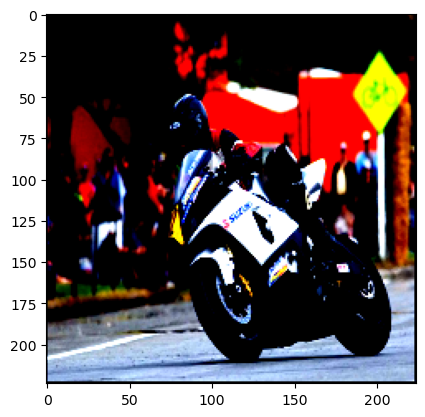

In [147]:
image, label = val_set[2000]
print(label)
label.to(device)
print(image, label.to(device))
plt.imshow(image.permute(1,2,0))

In [ ]:
from sklearn.metrics import mean_absolute_error
print(label)
print(y_pred[0])
mean_absolute_error(label.cpu(), y_pred[0].cpu())

In [ ]:
print(criterion(baseline_model(train_set[0][0].to(device).unsqueeze(0)).to(device),label.unsqueeze(0).to(device)))

In [ ]:
print(torch.sigmoid(baseline_model(train_set[0][0].to(device).unsqueeze(0))))

In [ ]:
from torchvision.datasets import VOCDetection

In [ ]:
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),])

valid_transformer = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),])

dataset = VOCDetection(root='data/',year ='2007', download=True, transform=transform_train())

test_dataset = VOCDetection(root='data/', year = '2007',image_set='val', transform=transform_test())